# Homework 1
In this homework, we will go through what we learned during the first three weeks, including basic linear algebra, least squares method, feature descriptor and matching, and bag of visual words.

You should finish this homework in this `hw1.ipynb` file using our provided templates. You can add other functions to solve the problems if necessary, but please only add them in this file.

The due for this homework is 12:00pm, Oct. 18th, Friday. We decided to prolong the time for you to finish this homework. Please submit this `hw1.ipynb` to Gradescope.

In the assignment folder, you will see:
- `features.py`, which contains some auxilary functions that help you extract and visualize keypoints;
- `*.png` and `*.jpg` files, which are some images you will work on in the feature descriptor question;
- `database` and `query` folders, which contain images of 5 classes selected from the famous ImageNet dataset, to be used to build bag of visual words for the last question;
- `hw1.ipynb`, which is the file you will work on and submit. Please only write your answers here.

In [72]:
# Setup

import random  # pseudo random number generator library
import numpy as np
from skimage import filters  # if skimage not installed, try "python3 -m pip install scikit-image"
from skimage.feature import corner_peaks
from skimage.io import imread
import matplotlib.pyplot as plt
from time import time
import math


# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1: Numpy Practice (10 points)
This question asks basic Numpy operations. Most questions already give you the right answer to check your implementation.

## Question 1.1 (2 points)
Define the following using numpy:

$$M = \begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9 \\
10 & 11 & 12 \end{bmatrix}
$$

$$a = \begin{bmatrix}
1 \\ 3 \\ 1
\end{bmatrix}
$$

$$b = \begin{bmatrix}
-1 \\ 5 \\ 2
\end{bmatrix}  
$$

Hint: 
1. in Numpy, a 1-dimensional vector represents a column vector
2. if you want to review Numpy programming, check discussion 1 material on the course website (under the Schedule & Assignment tab).

In [3]:
### YOUR CODE HERE
M = np.arange(1, 13).reshape(4, 3)
a = np.array([1, 3, 1])
b = np.array([-1, 5, 2])
### END OF CODE
print("M = \n", M)
print("a = \n", a)
print("b = \n", b)

M = 
 [[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]
a = 
 [1 3 1]
b = 
 [-1  5  2]


## Question 1.2 (2 points)
Compute the dot product between $a$ and $b$ using numpy: $c = a^Tb$.

In [4]:
# YOUR CODE HERE
c = np.dot(a.T, b)
# END OF CODE

assert c == 16

## Question 1.3 (2 points)
Compute $(a^T b)Ma$ using Numpy

In [5]:
# YOUR CODE HERE
ans = np.dot(np.dot(c, M), a)
# END OF CODE

assert ans[0] == 160 and ans[1] == 400 and ans[2] == 640 and ans[3] == 880

## Question 1.4 (2 points)
Perform Singular Value Decomposition with Numpy:
$$M = U\Sigma V^T$$
In the equation above, $\Sigma$ is a matrix with only diagonal elements, but in the question below, we only need the numbers on the diagonal.

In [6]:
# YOUR CODE HERE
# Decompose M (4x3 matrix) into U,S,V. where U is a 4x4 matrix, VT is a 3x3 matrix, and S is the singular values (a vector of size 3, the diagnoal of Sigma)
U,S,VT = np.linalg.svd(M)
# END OF CODE

print(S)

[2.54624074e+01 1.29066168e+00 2.31173375e-15]


## Question 1.5 (2 points)
Perform eigen decomposition on the following matrix.

$$
M = \begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9 \end{bmatrix}
$$
Find the largest eigenvalue and the corresponding eigenvector.

In [7]:
M = np.array([[1,2,3],[4,5,6],[7,8,9]])
# YOUR CODE HERE
eigen_values, eigen_vectors = np.linalg.eig(M)
largest_eigen_value = np.max(eigen_values)
eigen_vector_for_largest_eigen_value = eigen_vectors[np.argmax(eigen_values)]
# END OF CODE
print(eigen_values)
print(eigen_vectors)
print(largest_eigen_value)
print(eigen_vector_for_largest_eigen_value)

[ 1.61168440e+01 -1.11684397e+00 -1.30367773e-15]
[[-0.23197069 -0.78583024  0.40824829]
 [-0.52532209 -0.08675134 -0.81649658]
 [-0.8186735   0.61232756  0.40824829]]
16.116843969807043
[-0.23197069 -0.78583024  0.40824829]


# Question 2 Least Squares Method (20 points)

## Question 2.1 Over-determined System and  Under-determined System (6 points)

1. consider a system of 4 equations and 3 unknowns $(X, Y, Z)$, which is overdetermined (more equations than unknowns). (3 points)

$$
\begin{bmatrix}
2 & 1 & 1 \\
-3 & 4 & 1 \\
-1 & 10 & 3 \\
-4 & 2 & 2\\
\end{bmatrix}\begin{bmatrix}
X \\
Y \\
Z \\
\end{bmatrix} = \begin{bmatrix}
1 \\
5 \\
2 \\
2 \\
\end{bmatrix}
$$
2. consider a system of 2 equations and 3 unknowns $(X, Y, Z)$, which is underdetermined (fewer equations than unknowns). (3 points)
$$
\begin{bmatrix}
-3 & 4 & 1 \\
-1 & 10 & 3 \\
\end{bmatrix}\begin{bmatrix}
X \\
Y \\
Z \\
\end{bmatrix} = \begin{bmatrix}
5 \\
2 \\
\end{bmatrix}
$$

Find solutions for 1 and 2. If there is no solution, write down your proof.

Write down your calculation or proof of Question 2.1 here:
<br></br>
1) There is no solution to the system because the system is inconsistent as the following shows:

\begin{pmatrix}-4&2&2&2\\ 0&\frac{19}{2}&\frac{5}{2}&\frac{3}{2}\\ 0&0&\frac{28}{19}&\frac{32}{19}\\ 0&0&0&\frac{31}{7}\end{pmatrix}
Thus, because the system is inconsistent as 0 does not equal 31.
<br></br>

2) The underdetermined system presented has infinite solutions. One solution is where we set Z = 1 and solve for X & Y. 
$$
\begin{bmatrix}
-3 & 4 & 1 \\
-1 & 10 & 3 \\
\end{bmatrix}\begin{bmatrix}
X \\
Y \\
1 \\
\end{bmatrix} = \begin{bmatrix}
5 \\
2 \\
\end{bmatrix}
$$

In RREF form the matrix becomes: 
$$
\begin{bmatrix}
1 & 0 & \frac{1}{13} \\
0 & 1 & \frac{4}{13} \\
\end{bmatrix}\begin{bmatrix}
X \\
Y \\
1 \\
\end{bmatrix} = \begin{bmatrix}
-\frac{21}{13} \\
\frac{1}{26} \\
\end{bmatrix}
$$

And then we can solve the system and discover a solution: $$X = -\frac{22}{13}, ~ ~ ~Y = -\frac{7}{13}, ~~~ Z = 1$$

<br></br>
<br></br>
<br></br>
<br></br>

## Question 2.2 Compute Pseudo Inverse (2 points)

Implement the get_pinv method, which takes a matrix as input, and outputs its pseudo inverse. Please call get_pinv (written by yourself) to calculate the pseudo-inverse of the two matrices:

$$
A_1 = \begin{bmatrix}
2 & 1 & 1 \\
-3 & 4 & 1 \\
-1 & 10 & 3 \\
-4 & 2 & 2\\
\end{bmatrix}, A_2 = \begin{bmatrix}
-3 & 4 & 1 \\
-1 & 10 & 3 \\
\end{bmatrix}
$$

(Hint: $A^\dagger = V\Sigma^{-1}U^T$)  
You may use np.linalg.svd, but you may not use np.linalg.pinv. (You may secretly use it to check you answer. We won't know)

In [166]:
def get_pinv(matrix):
    """ Implement the pseudo inverse of a matrix
    Args:
        matrix: a numpy array with shape (m,n)

    Returns:
        out: the pseudo inverse of input matrix
    """
    ### YOUR CODE HERE
    U, D, V = np.linalg.svd(matrix)   
    D = np.diag(np.reciprocal(D))
    D = np.concatenate((D, np.zeros((1, len(D)))))
    U, V = U.T, V.T
    if V.shape[0] <= U.shape[0]:
        D = D.T
    out = np.matmul(V, np.matmul(D, U))
    
    ### END YOUR CODE

    return out

In [10]:
A_1 = np.array([[2, 1, 1], [-3,4,1],[-1, 10, 3], [-4, 2, 2]])
A_2 = np.array([[-3,4,1], [-1, 10, 3]])
pinv_A_1 = get_pinv(A_1)
pinv_A_2 = get_pinv(A_2)
print(pinv_A_1)
print(pinv_A_2)

[[ 0.15400411 -0.12217659  0.0523614  -0.09445585]
 [-0.10677618  0.09137577  0.1036961  -0.14784394]
 [ 0.46748802 -0.26865161 -0.02772074  0.4421629 ]]
[[-0.38172043  0.15053763]
 [-0.02688172  0.10215054]
 [-0.03763441  0.04301075]]


## Question 2.3 Least squares solution for an over-determined system (4 points)
For an over-determined linear system $Ax = b$ where $A\in\mathbb{R}^{m\times n}, m>n$, there may not be any solution. However, we can formulate the following least square problem to obtain the best approximation that minimizes the residual of $Ax-b$:

$$\min_x \|Ax - b\|^2$$

1. Show that $A^\dagger = (A^T A)^{-1}A^T$ for a tall $A$ matrix. (Hint: check the hint of Question 2.1)
2. Show that the solution to the above optimization can be written using the pseudo-inverse $A^\dagger$ of matrix $A$: $x=A^\dagger b$ (Hint: Calculate gradient to $x$)

Write down your proof of Question 2.2 here:
<br></br>
1. 
We know that $A^\dagger = V\Sigma^{-1}U^T$ (1)
<br></br>
In order to show that $$A^\dagger = (A^T A)^{-1}A^T$$ (2), we expand this equation and attempt to simplify to the previous equation.
$$A^\dagger = ((V^T \Sigma U)(U \Sigma V^T))^{-1}(V \Sigma U^T)$$
<br></br>
$$= (V \Sigma U^T U \Sigma V^T)^{-1} (V \Sigma U^T)$$
<br></br>
$$= V \Sigma^{-2} V^T V \Sigma U^T$$
<br></br>
$$= V \Sigma^{-1} U^T$$
<br></br>
We are able to expand and simplify equation (2) into equation (1), and thus prove that $$A^\dagger = (A^T A)^{-1}A^T$$ 
<br></br>
<br></br>
2. $$||Ax - b||^{2}_{2} = (Ax - b)^{T}(Ax - b)$$
In order to find the minimum, we take the derivative of the expression with respect to x and set it equal to 0. 
<br></br>
Thus, we get: 
<br></br>
$$2(A^{T}A)x - 2A^{T}b = 0$$
<br></br>
And then solving for x: $$x = (A^{T}A)^{-1}A^{T}b$$
<br></br>
Then as we proved in (1), we can simplify the above equation and solve the optimization with the psuedo-inverse as follows: 
<br></br>
$$x = A^{\dagger}b$$
<br></br>

## Question 2.4 Minimum norm solution for an under-determined system (6 points)
For an under-determined system $Ax = b$ where $A\in\mathbb{R}^{m\times n}, m < n$, there can be infinite solutions (in fact, a linear space), thus we cannot return a unique answer. However, there is one solution that has the minimum $\ell_2$-norm. The minimum norm solution is obtained by solving this optimization problem:

\begin{equation}
\begin{aligned}
&\min_{x} & &\|x\|^2\\
& \text{subject to} & &Ax - b = 0
\end{aligned}
\end{equation}

1. Show that $A^\dagger = A^T(AA^T)^{-1}$ for a fat matrix.


Write down your proof of Question 2.3 here:
<br></br>
<br></br>
We can assume from prior knowledge that $A = U \Sigma V^{T}$ and $A^{T} = V\Sigma U^{T}$
<br></br>
Then, we can begin simplifying $$A^{T}(AA^{T})^{-1}$$
<br></br>
$$= V \Sigma U^{T}(U\Sigma V^{T}V\Sigma U^{T})^{-1}$$
<br></br>
$$= V \Sigma U^{T}(U\Sigma^{2}U^{T})^{-1}$$
<br></br>
$$= V \Sigma U^{T}(U\Sigma^{-2}U^{T})$$
<br></br>
$$= V \Sigma^{-1}U^{T}$$
<br></br>
$$= A^{\dagger}$$
<br></br>
Thus we show that $A^\dagger = A^T(AA^T)^{-1}$ for a fat matrix.
<br></br>
<br></br>
2. Prove that for underdetermined system, $A^\dagger b$ gives the optimal solution to the minimum norm problem. (Hint: Use the Lagrangian multipliers method)
<br></br>
<br></br>
Using the Lagrangian multipliers method, we show that, for an undetermined system, $A^\dagger b$ gives the optimal solution
<br></br>
<br></br>
We set $ L(x, \lambda) = ||x||^2_2 + \lambda^{T}(Ax - b)$
<br></br>
Then we take the derivative of L with respect to both x and $\lambda$
<br></br>
<br></br>
$$\frac{\delta L}{\delta x} = 0$$
<br></br>
$$\frac{\delta L}{\delta \lambda} = 0$$
<br></br>
We can simplify the equation to $ L(x, \lambda) = x^{T}x + \lambda^{T}(Ax - b)$ and take the derivative to get 
<br></br>
$$\frac{\delta L}{\delta x} = 2x + A^{T}\lambda = 0$$
<br></br>
$$\frac{\delta L}{\delta \lambda} = Ax - b = 0$$
<br></br>
Thus, $$x = -A^T \frac{\lambda}{2}$$
<br></br>
and we can substitute into the second equation to get 
<br></br>
$$\lambda = -2(AA^{T})^{-1}b$$
<br></br>
and then we can substitute $$\lambda = -2A^{-1}x$$
<br></br>
Ultimately ending with 
$$ x = A^{T}(AA^{T})^{-1}b = A^\dagger b$$
<br></br>
and proving that $A\dagger b$ can be used to solve the minimum norm problem.

## Question 2.5 Finish the calculation (2 points)
Implement a method called linear_solver, to solve the least squares problem or minimum norm problem for $Ax = b$. 

It takes matrix $A, b$ as input, and output a vector, which is the solution. For the linear equations in Question 2.1, use this solver to compute the solution for least squares problem (2.1.1) or minimum norm problem (2.1.2).




In [169]:
def linear_solver(matrix, vector):
    """ Implement a linear solver of a least squares problem/minimum norm problem
    Args:
        matrix: input matrix on LHS
        vector: target vector on RHS
    Returns:
        out: the solution for least squares problem/minimum norm problem
    """
    p_inv = get_pinv(matrix)
    ### YOUR CODE HERE
    out = np.dot(p_inv, vector)
    ### END YOUR CODE
    return out

In [170]:
A_1 = np.array([[2, 1, 1], [-3, 4, 1],[-1, 10, 3], [-4, 2, 2]])
A_2 = np.array([[-3, 4, 1], [-1, 10, 3]])
b_1 = np.array([1, 5, 2, 2])
b_2 = np.array([5, 2])
ls_res = linear_solver(A_1, b_1)
min_norm_res = linear_solver(A_2, b_2)
print('least square result', ls_res)
print('minimum norm result', min_norm_res)

least square result [-0.54106776  0.26180698 -0.04688569]
minimum norm result [-1.60752688  0.06989247 -0.10215054]


# Question 3: Local Feature Descriptors and Matching (30 points)

In this part, you will be implementing keypoint detector, feature descriptors,
and feature matching. Keypoint detectors find salient points in an image, such
as corners. Using information surrounding a keypoint, we can extract a feature descriptor. Once we
have descriptors, we can use them to match keypoints between images by measuring feature similarities.

## Prerequesite: Image Filtering and Box filter
Load the `chair.png` image and we can smooth it by a $5\times 5$ box filter by the following code:

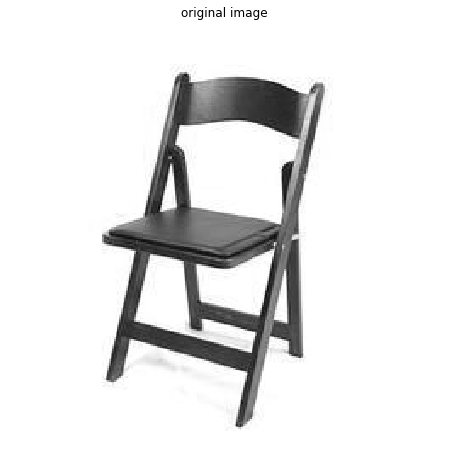

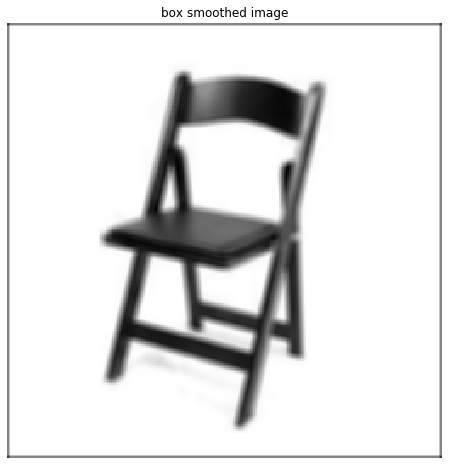

In [162]:
from scipy.signal import convolve
from skimage import filters

I = imread('chair.jpg', as_gray=True)
plt.imshow(I)
plt.axis('off')
plt.title('original image')
plt.show()

window_size = 5
box_filter=np.ones((window_size, window_size))/(window_size*window_size) # define a box filter
I_box = convolve(I, box_filter, mode='same')
plt.imshow(I_box)
plt.axis('off')
plt.title('box smoothed image')
plt.show()

Note that we do not need to flip the kernel when using the convolve function provided by scipy.signal, because this function really just does the `correlation` (or filtering) operation, instead of the true `convolution` defined in math books. Nonetheless, let us just get used to this engineering convention and call the scipy.signal.convolve to compute the filtering.



## Question 3.1 Vertical Edge filter (5 points)

Use you favorate vertical edge filter to extract vertical edges from the `chair.jpg` image

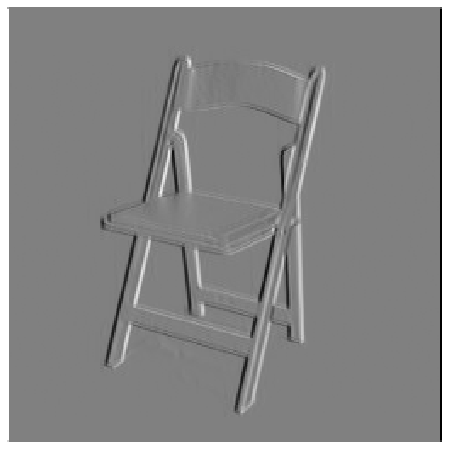

In [163]:
img = imread('chair.jpg', as_gray=True)
I_vert_edge = None

### YOUR CODE HERE

filter = np.array([[1, 0, -1], [0, 0, 0], [2, 0, -2]])
I_vert_edge = convolve(img, filter, mode='same')
''' OR you can use filters.sobel_v(img) -- I wasn't sure which to do '''

### END YOUR CODE

plt.imshow(I_vert_edge)
plt.axis('off');

## Question 3.2 Harris Corner Detector and Feature Matching (15 points)
In this question, you are going to implement Harris corner detector for keypoint localization. Review the lecture slides on Harris corner detector to understand how it works. The Harris detection algorithm can be divide into the following steps:
1. Compute $x$ and $y$ derivatives ($I_x, I_y$) of an image
2. Compute products of derivatives ($I_x^2, I_y^2, I_{xy}$) at each pixel
3. Compute matrix $M$ at each pixel, where
$$
M(x_0,y_0) = \sum_{x,y} w(x-x_0,y-y_0)
    \begin{bmatrix}
        I_{x}^2 & I_{x}I_{y} \\
        I_{x}I_{y} & I_{y}^2
    \end{bmatrix}
$$
Here, we set weight $w(x,y)$ to be a box filter of size $3 \times 3$ (the box is placed centered at $(x_0, y_0)$).

This looks slightly more complicated than what we taught in class. But if you stare at the equation for a while, you will realize that this is just the "smoothed" version of the $M$ we taught in class, smoothed by a box filter $w$. Obviously, the smoothing should be done by a filtering operation.
4. Compute corner response $R=Det(M)-k(Trace(M)^2)$ at each pixel
5. Output corner response map $R(x,y)$


Step 1 is already done for you in the function **`harris_corners`**. You need to complete the function implementation and run the code below.

- Hint: You may use the function `scipy.signal.convolve`.  
You may refer to `chair_harris_ground_truth.png` for the expected output.

In [34]:
def harris_corners(img, window_size=3, k=0.04):
    """
    Compute Harris corner response map. Follow the math equation
    R=Det(M)-k(Trace(M)^2).

    Hint:
        You may use the function scipy.signal.convolve,
        which is already imported above

    Args:
        img: Grayscale image of shape (H, W)
        window_size: size of the window function
        k: sensitivity parameter

    Returns:
        response: Harris response image of shape (H, W)
    """

    H, W = img.shape
    window = np.ones((window_size, window_size))

    response = np.zeros((H, W))

    box_filter=np.ones((window_size, window_size))/(window_size*window_size) # define a box filter
    
    dx = filters.sobel_v(np.squeeze(img)) 
    dy = filters.sobel_h(np.squeeze(img))
    
    # convolve and square before hand for computational efficiency
    dx2 = convolve(np.square(dx), box_filter, mode='same')
    dy2 = convolve(np.square(dy), box_filter, mode='same')
    dxy = convolve(dx * dy, box_filter, mode='same')

    ### YOUR CODE HERE
    for i in range(H):
        for j in range(W):
            M = np.array([[dx2[i, j], dxy[i, j]], [dxy[i, j], dy2[i, j]]])
            response[i, j] = np.linalg.det(M) - k * np.trace(M)**2
    ### END YOUR CODE
    
    return response

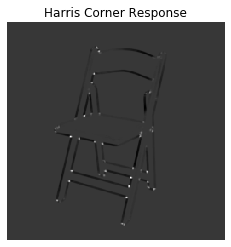

In [35]:
img = imread('chair.jpg', as_gray=True)

# Compute Harris corner response
response = harris_corners(img)

# Display corner response
plt.imshow(response)
plt.axis('off');
plt.title('Harris Corner Response');

## Question 3.3 Histogram of Oriented Gradients (10 points)
In this section, you are going to implement a simplified version of HOG descriptor. Similar to the SIFT feature introduced in class, HoG is also based on image gradients but with fewer engineering tricks. We implement (a simplied) HoG instead of SIFT to get some taste of image feature engineering.

HOG stands for Histogram of Oriented Gradients (Histograms of oriented gradients for human detection, by N. Dalal and B. Triggs). In HOG descriptor, the distribution (histograms) of directions of gradients (oriented gradients) are used as features. Gradients (x and y derivatives) of an image are useful because the magnitude of gradients is large around edges 
and corners (regions of abrupt intensity changes) and we know that edges and corners pack in a lot more information about object shape than flat regions.
The steps of HOG are:
1. compute the gradient image in x and y  
    Use the sobel filter provided by `skimage.filters.sobel_h` and `skimage.filters.sobel_v`
2. compute gradient histograms  
    Divide image into patches, each of which contains $16 \times 16$ pixels. 
3. A patch is then evenly partitioned as $2 \times 2$ cells. Then calculate the histogram of gradients in each cell, with each cell contains $8 \times 8$ pixels. Normalize the gradient vector in each cell to be a unit vector. 
4. concatenate the unit vectors of each cell in a patch to be a single vector for encoding the patch

The function `corner_peaks` from `skimage.feature` performs non-maximum suppression to take local maxima of the response map and localize keypoints. You can just regard this function as a keypoint selection module given some manually designed thresholds.

In [36]:
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import euclidean_distances

def pairwise_euclidean_distance(feature1, feature2):
    """
    Args:
    assert S.shape == (feature1.shape[0], feature2.shape[1])
    assert S.shape == (feature1.shape[0], feature2.shape[1])
        feature1: numpy array with shape (N, k)
        feature2: numpy array with shape (M, k)
    Returns:
        S: numpy array with shape (N, M) where S[i,j] is the l2 distance between feature1[i] and feature2[j]
    """
    # YOUR CODE HERE
#     S = pdist(np.concatenate(feature1, feature2), metric='euclidean')
    S = euclidean_distances(feature1, feature2)
    # END OF CODE
    return S

def hog_descriptor(patch, pixels_per_cell=(8,8)):
    """
    Generating hog descriptor by the following steps:

    1. compute the gradient image in x and y (already done for you)
    2. compute gradient histograms
    3. normalize across cells
    4. flattening cells into a feature vector

    Args:
        patch: grayscale image patch of shape (h, w)
        pixels_per_cell: size of a cell with shape (m, n)

    Returns:
        cells: 1D array of shape ((h*w*n_bins)/(m*n))
    """
    assert (patch.shape[0] % pixels_per_cell[0] == 0), \
        'Heights of patch and cell do not match'
    assert (patch.shape[1] % pixels_per_cell[1] == 0), \
        'Widths of patch and cell do not match'

    n_bins = 9
    degrees_per_bin = 180 // n_bins

    Gx = filters.sobel_v(patch)
    Gy = filters.sobel_h(patch)

    # Unsigned gradients
    G = np.sqrt(Gx**2 + Gy**2)
    theta = (np.arctan2(Gy, Gx) * 180 / np.pi) % 180

    G_cells = view_as_blocks(G, block_shape=pixels_per_cell) # view_as_blocks is a function from skimage, which partitions a patch G into cells of pixels_per_cell size
    theta_cells = view_as_blocks(theta, block_shape=pixels_per_cell)
    
    rows = G_cells.shape[0]
    cols = G_cells.shape[1]
    cells = np.zeros((rows, cols, n_bins))
    
    # Compute histogram per cell

    ### YOUR CODE HERE
    for row in range(rows):
        for col in range(cols):
            G_cell, theta_cell = G_cells[row, col], theta_cells[row, col]
            hist_bin = np.zeros((n_bins))
            for lower, upper in [(degrees_per_bin * i, degrees_per_bin * (i + 1)) for i in range(n_bins)]:
                t_mask = ((theta_cell >= lower) & (theta_cell < upper)).astype(int)
                # you can skip the g_mask step to replicate the results from the given example correspondences :)
                g_mask = t_mask * G_cell
                hist_bin[int(lower/degrees_per_bin)] += np.sum(g_mask.flatten())
                cells[row, col] = hist_bin
    
    cells = np.ravel(cells)
    norm = np.sum(np.square(cells))
    cells = cells/norm
    
    assert cells.shape[0] == rows * cols * n_bins
    ### YOUR CODE HERE

    return cells

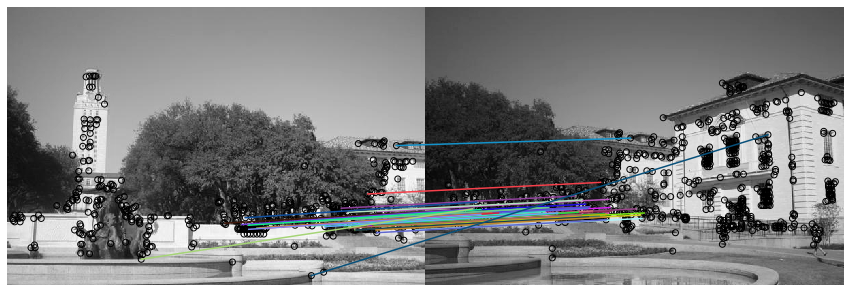

In [37]:
from features import describe_keypoints, plot_matches, match_descriptors
from skimage.util.shape import view_as_blocks

img1 = imread('uttower1.jpg', as_gray=True)
img2 = imread('uttower2.jpg', as_gray=True)

# Detect keypoints in both images
keypoints1 = corner_peaks(harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

# Extract features from the corners
desc1 = describe_keypoints(img1, keypoints1,
                           desc_func=hog_descriptor,
                           patch_size=16)

desc2 = describe_keypoints(img2, keypoints2,
                           desc_func=hog_descriptor,
                           patch_size=16)

# Match descriptors in image1 to those in image2. 
# You can read into match_descriptors and adjust the last parameter to see what will happen, which is a threshold for screening correspondences
matches = match_descriptors(desc1, desc2, pairwise_euclidean_distance, .75)

# Plot matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
ax.axis('off')
plot_matches(ax, img1, img2, keypoints1, keypoints2, matches)
plt.show()
# compare your result with the provided `correspondence_ref_result.png`

# Question 4: Visual Words and Image Retrieval (40 points)

We are now able to extract features using a simplified HOG. The next question is, how can we discribe an image by our feature discriptor? Recall what we learned about visual words, we can build a visual vocabulary by clustering the local features.

## Question 4.1: 1-D KMeans (5 points)

Consider a very simple one-dimensional dataset. The data points are **2, 5, 12, 20, 23, 26**.

Run the algorithm using two clusters, where the initial guesses for the cluster centers are 3.5 (cluster 1) and 5.0 (cluster 2).
For each step of the K-Means algorithm, specify the entries in each cluster and calculate the new mean
below. Assume that a step consists of assigning points to each cluster and computing the new mean. If it
converges in fewer than five steps, you may leave the remaining steps blank.

You can manually calculate the answers or write an program. You only need to provide a final answer below.

Step 1:

Cluster index of [2, 5, 12, 20, 23, 26]:  [1, 2, 2, 2, 2, 2] (an example here)

Cluster 1 new mean: 2

Cluster 2 new mean: 17.2

Step 2:

Cluster index of [2, 5, 12, 20, 23, 26]: [1, 1, 2, 2, 2, 2]

Cluster 1 new mean: 3.5

Cluster 2 new mean: 20.25

Step 3:

Cluster index of [2, 5, 12, 20, 23, 26]: [1, 1, 2, 2, 2, 2]

Cluster 1 new mean: 3.5

Cluster 2 new mean: 20.25

### Converged!

Step 4:

Cluster index of [2, 5, 12, 20, 23, 26]:

Cluster 1 new mean: 

Cluster 2 new mean:

Step 5:

Cluster index of [2, 5, 12, 20, 23, 26]:

Cluster 1 new mean:

Cluster 2 new mean:

## Question 4.2: Construct Visual Words

There are four steps for you to construct the visual words for an image

1. Divide an image into patches
2. Cluster the patches through K-Means and build the visual vocabulary
3. Index patches by the ID of the nearest cluster center (visual word)
4. Build a histogram of visual words by aggregating cluster IDs of patches in the entire image

We first implement a function to load all images in a folder for you:

In [75]:
import os
def read_image(image_path):    
    files = os.listdir(image_path)
    images = []
    for fi in files:
        if fi.endswith('.JPEG') or fi.endswith('.jpg') or fi.endswith('.jpeg'):
            image = imread(os.path.join(image_path, fi), as_gray=False)
            images.append(image)
    return np.array(images)

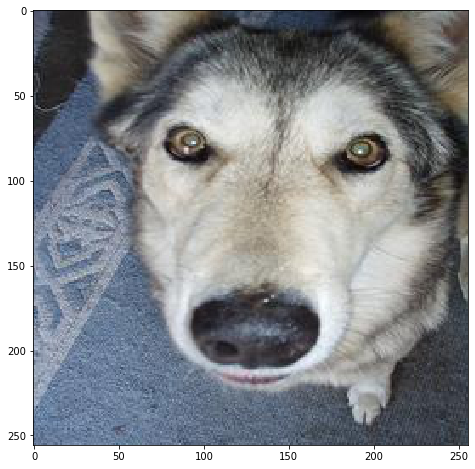

In [76]:
all_images = read_image('./database')
plt.imshow(all_images[0])  # have a look at the first image

### 4.2.1 Images to patches (5 points)
Implement the following function based on the comments. 
You may use any function from `sklearn.feature_extraction`, but it is not required.

The input images are already resized to $256\times 256\times 3$. Decompose each image densely and evenly as patches without overlapping. The patch_size by default is $16$, which is both the width and height of the patch. As a result, there should be $16\times 16$ patches.

In [6]:
def images_to_patches(images, patch_size):
    """
    Args:
        images: numpy array with shape (N, H, W, 3)  where N is total number of images, H is width, W is height
        patch_size: size of a square patch (patch_size, patch_size) 

    Returns:
        patches: numpy array with shape (M, 16, 16, 3) where M is total number of patches (a lot)
    """
    
    ### YOUR CODE HERE
    patches = []
    for image in images:
        W, H, D = image.shape
        patch = image.reshape(W//patch_size, patch_size, H//patch_size, patch_size, D).swapaxes(1, 2).reshape(-1, patch_size, patch_size, D)
        patches.extend(patch)
    patches = np.array(patches)
    ### END OF CODE
    
    return patches

In [7]:
patches = images_to_patches(all_images, 16)
color_patches = patches.reshape([-1, 16*16*3])  # (M, 768), each patch is represented by flattened color channels

### 4.2.2 KMeans (5 points)
You need to implement the `fit_kmeans` function to fit color_patches.

You may use `sklearn.cluster.KMeans`.

In [8]:
from sklearn.cluster import KMeans

In [9]:
def fit_kmeans(data, n_clusters=100):
    """
    Args:
        data: numpy array with shape (N, k), N is the number of data points, k is the dimension of feature vector.
        n_clusters: cluster number

    Returns:
        out: sklearn.cluster.KMenas model
    """
    ### YOUR CODE HERE
    kmeans = KMeans(n_clusters=n_clusters).fit(data) 
    ### END OF CODE
    
    return kmeans

Run kmeans on patches to build the visual vocabulary. (It will take a while)

In [10]:
kmeans_model = fit_kmeans(color_patches)

### 4.2.3 Plot clusters (5 points)
Randomly choose 10 clusters from the Kmeans result. Plot 5 original patches ($16\times 16\times 3$) displayed in color for each of the clusters.
Hint: use the `predict` function from `sklearn.cluster.KMeans`

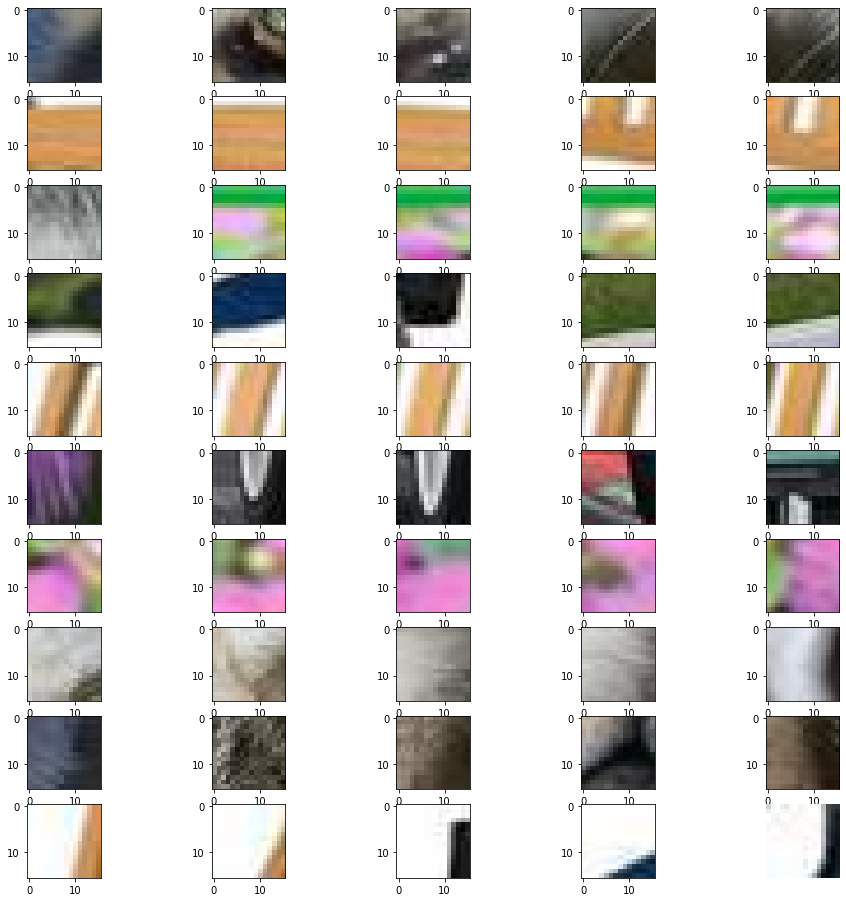

In [55]:
import numpy as np
import matplotlib.pyplot as plt

rand_clusters = {random.randint(0,100): [] for i in range(10)}
cluster_count = {key: 0 for key in rand_clusters}
for patch, pred in zip(patches, kmeans_model.predict(color_patches)):
    if pred in rand_clusters and cluster_count[pred] < 5:
        rand_clusters[pred].append(patch)
        cluster_count[pred] += 1
    if sum([val for key, val in cluster_count.items()]) >= 50:
        break
        
fig = plt.figure(figsize = (16, 16))

count = 1
rows, cols = 10, 5

for key in rand_clusters:
    for image in enumerate(rand_clusters[key]):
        fig.add_subplot(rows, cols, count)
        plt.imshow(image[1].reshape(16, 16, 3) / 255)
        count += 1
plt.axis('off')
plt.show()

### 4.2.4 Visual word (10 points)
Implement `get_patch_indices` and `get_visual_words` functions below.

In [109]:
def get_patch_indices(patches, kmeans_model):
    """
        Args:
            patches: numpy array with shape (N, 16, 16, 3), where N is the number of batches
            kmeans_model: already fitted k-means model

        Returns:
            ind: the cluster indices that the patches belong to
    """

    ### YOUR CODE HERE
    s = patches.shape
    ind = kmeans_model.predict(patches.reshape(-1, s[1] * s[2] * s[3]))
    ### END YOUR CODE

    return ind

def get_visual_words(image, kmeans_model, patch_size=16):
    """
    Args:
        image: numpy array with shape (H, W, 3), which is a single image
        kmeans_model: the fitted kmeans model
        patch_size: size of a square patch

    Returns:
        hist: histogram of visual words that describes the images
    """
    patches = images_to_patches(image[None, :], patch_size=patch_size) 
    # image[None, :] means expand the shape (H, W, 3) to (1, H, W, 3), so that is will fit your previous implementation of images_to_patches
    visual_words = get_patch_indices(patches, kmeans_model)
    
    # build histogram
    hist = np.zeros((kmeans_model.n_clusters))
    
    ### YOUR CODE HERE
    unique, count = np.unique(visual_words, return_counts=True)
    for idx, count in zip(unique, count):
        hist[idx] = count
    ### END YOUR CODE

    return hist

Read 5 query images from the `./query` foler

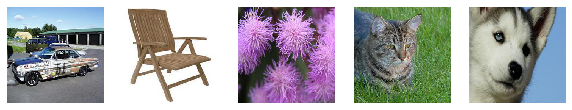

In [47]:
test_images = read_image('./query')
for i in range(test_images.shape[0]):
    plt.subplot(1, 5, i+1)
    plt.imshow(test_images[i])
    plt.axis('off')

### 4.2.5 Image retrieval (10 points)
For each image in the `./database` folder, compute its bag of visual words representation. Then for each image in the `./query` folder, compute its bag of visual words representation.

For each test image, find 5 most similar images from the `./database` folder using cosine similarity between their bag of visual words representations, and plot them.

In [146]:
from time import time

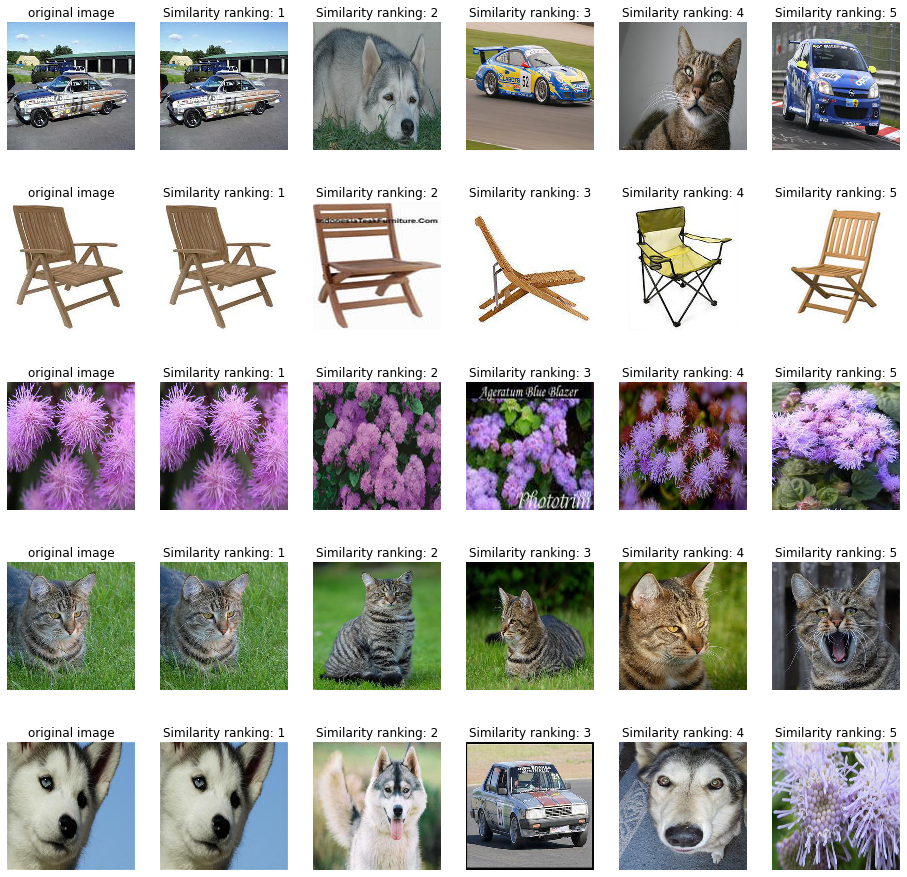

In [160]:
all_visual_words = np.array([get_visual_words(img, kmeans_model) for img in all_images])
all_test_words = np.array([get_visual_words(img, kmeans_model) for img in test_images])

### YOUR CODE HERE
from sklearn.metrics.pairwise import cosine_similarity

count = 1
rows, cols = len(all_test_words), 6
fig = plt.figure(figsize = (16, 16))

sims = cosine_similarity(all_test_words, all_visual_words)
for test_idx, test_img in enumerate(sims):
    top_5 = sorted(zip(range(len(test_img)), test_img), key=lambda x: x[1], reverse=True)[:5]
    fig.add_subplot(rows, cols, count)
    plt.imshow(test_images[test_idx].reshape(256, 256, 3) / 255)
    plt.title('original image')
    plt.axis('off')
    count += 1
    for rank, (all_idx, similarity) in enumerate(top_5):
        fig.add_subplot(rows, cols, count)
        plt.imshow(all_images[all_idx].reshape(256, 256, 3) / 255)
        plt.title(f'Similarity ranking: {rank + 1}')
        plt.axis('off')
        count += 1
plt.show()
### END YOUR CODE

Do you notice any unexpected retrival results? Explain why.

The BoW model returned some mismatches in the dog and car categories. This mainly occurs because the (16, 16) patches can be very similar depending on the image. For example the dog's fur and the road are very similar and will generate similar histograms. The background of the cat image will generate a similar histogram due to the road in the car images. The model does not take into accont scale or local context of the patches and thus fails to get generalizable results. 

### 4.2.6 Extra Credit (15 points)
Perform the whole image retrieval pipeline (4.2.1 - 4.2.5) with hog features. What are the differences in the final results compared to the color features? Explain.

Hint: load images in gray scale and perform the pipeline with gray scale